In [1]:
import random as r
from math import gcd
import sys
from os import system, name
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Task_Set = pd.read_excel('taskset1_EDFVD.xlsx')
print(Task_Set.head(5))

   task_id  C_LO  C_HI   T   D  Criticality_level  Release_time  \
0        1     2     3  20  20                  1           NaN   
1        2     4     6  20  20                  1           NaN   
2        3     6     6  20  20                  0           NaN   

   Virtual_deadline  
0               NaN  
1               NaN  
2               NaN  


In [3]:
#Calculating X：Ratio of Virtural deadline and real deadline
def calculate_X():
    u_lo_lo,u_hi,u_lo_hi,u_lo_total=0,0,0,0
    
    for index in range(len(Task_Set)):
        task = Task_Set.iloc[index]
        if task['Criticality_level']==0:
            u_lo_lo += task['C_LO']/task['T'];

        elif task['Criticality_level']==1:
            u_hi += task['C_HI']/task['T'];
            u_lo_hi += task['C_LO']/task['T'];
    
    u_lo_total=u_lo_lo + u_lo_hi;
    #ensuring that EDF-VD successfully schedules all LO-criticality behaviors
    X = u_lo_hi / (1-u_lo_lo);
    #ensuring that EDF-VD successfully schedules all HI -criticality behaviors
    chk = X * u_lo_lo + u_hi;
    if u_hi >1 or u_lo_total >1:
        print("Utilization is larger than 1, can't scheduling!!!");
        return -1;
    elif chk <=1:
        print("X is : %s"%round(X,2));
        return round(X,2);
    else:
        print("X is larger than 1, can't scheduling!!!");
        return -2;
    print("X is : %s"%round(X,2));
x = calculate_X();
print(x)

#Calculating Hyper Periods as LCM
def calculate_LCM():
    lcm = 0;
    for index in range(len(Task_Set)):
        task = Task_Set.iloc[index]
        if index == 0:
            lcm = int(task['T']);
        else:
            t = int(task['T']);
            lcm = int(lcm * t / gcd(lcm, t));
    return lcm
lcm = calculate_LCM()
print("Hyper Period is: ",lcm)

X is : 0.43
0.43
Hyper Period is:  20


In [4]:
# set VD
for index in range(len(Task_Set)):
    D = Task_Set.loc[index, 'D'];
    if Task_Set.iloc[index]['Criticality_level']==1:
        Task_Set.loc[index,'Virtual_deadline']= D*x;
    elif Task_Set.iloc[index]['Criticality_level']==0:
        Task_Set.loc[index,'Virtual_deadline'] = D;

print(Task_Set.head(5))

   task_id  C_LO  C_HI   T   D  Criticality_level  Release_time  \
0        1     2     3  20  20                  1           NaN   
1        2     4     6  20  20                  1           NaN   
2        3     6     6  20  20                  0           NaN   

   Virtual_deadline  
0               8.6  
1               8.6  
2              20.0  


In [5]:
# 判断是否有新的job生成进入可执行队列
# Check whether a new job is generated in this time. If have and move it the executable queue
'''
input：
    time(int): The time of total clock
    mode(int): Mode of system. 1 means high critical mode; 0 means low critical mode
    ready_que(pd.Dataframe): The ready executable queue of system
    fail_pro: Fail probability of high critical task.
output:
    ready_que(pd.Dataframe): The ready executable queue of system
'''
def release_job(time, mode, ready_que, fail_pro):
    if time==0:
        return ready_que;
    for index in range(len(Task_Set)):
        task = Task_Set.iloc[index]
        if (task['Criticality_level'] == mode) or (task['Criticality_level'] == 1):
            if time % task['T'] == 0:
                a = task.copy();
                a['Release_time'] = int(time);
                a['Job_id'] = int(time / task['T']);
                x = random.random();
                if (task['Criticality_level']==1 and x<=fail_pro) or (mode==1): #overrun case
                    a['Remain_execute_time'] = task['C_HI'];
                    a['Execute_time'] = task['C_HI'];
                else:
                    a['Remain_execute_time'] = task['C_LO'];
                    a['Execute_time'] = task['C_LO'];
  
                ready_que = ready_que.append(a, ignore_index=True);
    return ready_que;

In [6]:
#选择Vd最近的任务执行
# Choose the latest virtual deadline job to execute 1 unit time. If the job time out, then update the criticality mode to hight criticality.
'''
input：
    time(int): The time of total clock
    mode(int): Mode of system. 1 means high critical mode; 0 means low critical mode
    ready_que(pd.Dataframe): The ready executable queue of system
    histort(pd.Dataframe): The execution history for every unit time
    job_num(int): Total finished job of the system
output:
    ready_que(pd.Dataframe)
    mode(int)
    histort(pd.Dataframe)
    job_num(int)
'''
def execute_job(time, mode, ready_que, history, job_num):
    if(len(ready_que)==0):#如果目前准备队列中没有job, if there is no job in ready queue
        history = history.append({"Time":time}, ignore_index=True)
        return ready_que, mode, history, job_num;
    if mode == 0:
        Absolute_VD = ready_que['Release_time'] + ready_que['Virtual_deadline'];
        minidx = Absolute_VD.idxmin();
        ready_que.loc[minidx,'Remain_execute_time'] = ready_que.loc[minidx,'Remain_execute_time'] - 1;
        task_id = ready_que.loc[minidx,'task_id'];
        Job_id = ready_que.loc[minidx,'Job_id'];
        Remain_execute_time = ready_que.loc[minidx,'Remain_execute_time'];
        history = history.append({"Time":time, "task_id":task_id, "Job_id":Job_id, 'Remain_execute_time':Remain_execute_time}, ignore_index=True);
        if ready_que.loc[minidx,'Remain_execute_time'] == 0: #如果任务完成, if job is finished
            job_num = job_num + 1;
            if ready_que.loc[minidx,'Execute_time'] > ready_que.loc[minidx,'C_LO']:# 如果执行超时, if execution timeout
                mode = 1;
                ready_que = ready_que.drop(ready_que[ready_que['Criticality_level']==0].index)# drop low criticality jobs
            ready_que = ready_que.drop(minidx);#drop finished job
    elif mode == 1:
        Absolute_DDL = ready_que['Release_time'] + ready_que['D'];
        minidx = Absolute_DDL.idxmin();
        ready_que.loc[minidx,'Remain_execute_time'] = ready_que.loc[minidx,'Remain_execute_time'] - 1;
        task_id = ready_que.loc[minidx,'task_id'];
        Job_id = ready_que.loc[minidx,'Job_id'];
        Remain_execute_time = ready_que.loc[minidx,'Remain_execute_time'];
        history = history.append({"Time":time, "task_id":task_id, "Job_id":Job_id, 'Remain_execute_time':Remain_execute_time}, ignore_index=True);
        if ready_que.loc[minidx,'Remain_execute_time'] == 0: #如果任务完成, if job is finished
            job_num = job_num + 1;
            ready_que = ready_que.drop(minidx);
        
    return ready_que, mode, history, job_num;

In [7]:
# Main function of the EDV-FD schduling
'''
input：
    Totaltime(int): The Totaltime need to schduling
    fail_pro(float): Failure probability of high critical job to execute more than its C(LO)
    need_history(Boolean): Print the execution history or not
output:
    history(pd.Dataframe): Execution history for every unit time
    job_num(int): Total finished job of the system
'''
def EDFVD_Schduling(Totaltime, fail_pro, need_history=False):
    mode = 0; #Criticality mode of system
    time = 0; #Time clock of the system
    job_num = 0; #Total finished job of the system
    history = pd.DataFrame(); #History execution record of every unit time
    ready_que = Task_Set.copy(); #Initialize the ready job queue
    ready_que['Release_time'] = int(0);
    ready_que['Remain_execute_time'] = ready_que['C_LO'];
    ready_que['Execute_time'] = ready_que['C_LO'];
    ready_que['Job_id'] = int(0);
    
    if x < 0 :
        print("This dataset can not be scheduling!")
        return history, job_num;
    
    while time < Totaltime: #For every unit time
        #Release new job and random its execution time
        ready_que = release_job(time, mode, ready_que, fail_pro);
        #Choose the latest virtual deadline job to execute 1 unit time
        ready_que, mode, history, job_num = execute_job(time, mode, ready_que, history, job_num)
       
        time = time + 1;
    if need_history:
        print("Execution history for every unit time:");
        print(history);
        print("---------------------------------------");
    #print("Total task finished：",job_num);
    return history, job_num;

In [8]:
import matplotlib.pyplot as plt
# Random the fail ratio in [0.05, 0.2]. Get the utilization and average finish job numbers
# for different schduling time.
def test_schduling():
    x = [5, 10, 20, 40, 60, 80, 100]
    utilization = []
    Avg_jobnum = []
    for i in x:
        u_sum = 0;
        a_sum = 0;
        for j in range(3):
            fail_pro = random.uniform(0.05,0.2);
            Totaltime = i*lcm;
            history, finished_task = EDFVD_Schduling(Totaltime, fail_pro)
            not_use_time = pd.isna(history["task_id"])
            u = (Totaltime - len(history[not_use_time])) / Totaltime
            a_jn = finished_task/Totaltime
            u_sum = u_sum + u
            a_sum = a_sum + a_jn
        utilization.append(u_sum/3)
        Avg_jobnum.append(a_sum/3)
        print("Finish",i)
    
    fig, ax = plt.subplots()
    ax.plot(x, utilization, "or:")
    ax.set_ylim(ymin = 0, ymax = 1.0)
    ax.set_title("Utilization of EDF-VD")
    ax.set_xlabel("Total schduling time")
    ax.set_ylabel("Utilization")
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(x, Avg_jobnum, "og:")
    ax.set_title("Average finish job of EDF-VD")
    ax.set_xlabel("Total schduling time")
    ax.set_ylabel("Avg jobs per unit time")
    ax.set_ylim(ymin = 0, ymax = 0.4)
    plt.show()
    print("Utilization: ", utilization)
    print("Avg job nums: ", Avg_jobnum)

Finish 5
Finish 10
Finish 20
Finish 40
Finish 60
Finish 80
Finish 100


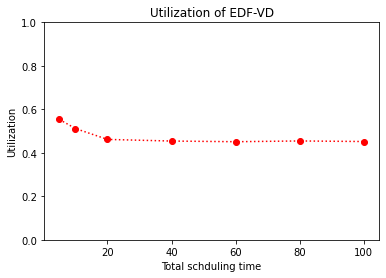

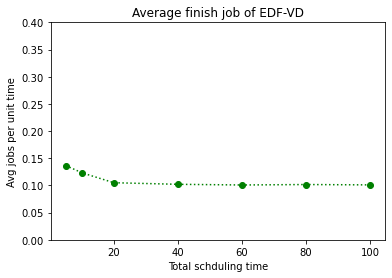

Utilization:  [0.5533333333333333, 0.5116666666666666, 0.46166666666666667, 0.45416666666666666, 0.4511111111111111, 0.45458333333333334, 0.45199999999999996]
Avg job nums:  [0.1366666666666667, 0.12333333333333334, 0.105, 0.10208333333333332, 0.10083333333333333, 0.10166666666666667, 0.10100000000000002]


In [9]:
test_schduling()